In [1]:
import json
f = open('datasets.json')
 
# returns JSON object as
# a dictionary
datasets = json.load(f)

# **Img.py**

In [45]:
import numpy as np
import scipy.misc
import cv2

# =============================================================================
# General image processing functions
# =============================================================================

def get_transform(center, scale, res, rot=0):
    # Generate transformation matrix
    h = 200 * scale
    t = np.zeros((3, 3))
    t[0, 0] = float(res[1]) / h
    t[1, 1] = float(res[0]) / h
    t[0, 2] = res[1] * (-float(center[0]) / h + .5)
    t[1, 2] = res[0] * (-float(center[1]) / h + .5)
    t[2, 2] = 1
    if not rot == 0:
        rot = -rot # To match direction of rotation from cropping
        rot_mat = np.zeros((3,3))
        rot_rad = rot * np.pi / 180
        sn,cs = np.sin(rot_rad), np.cos(rot_rad)
        rot_mat[0,:2] = [cs, -sn]
        rot_mat[1,:2] = [sn, cs]
        rot_mat[2,2] = 1
        # Need to rotate around center
        t_mat = np.eye(3)
        t_mat[0,2] = -res[1]/2
        t_mat[1,2] = -res[0]/2
        t_inv = t_mat.copy()
        t_inv[:2,2] *= -1
        t = np.dot(t_inv,np.dot(rot_mat,np.dot(t_mat,t)))
    return t

def transform(pt, center, scale, res, invert=0, rot=0):
    # Transform pixel location to different reference
    t = get_transform(center, scale, res, rot=rot)
    if invert:
        t = np.linalg.inv(t)
    new_pt = np.array([pt[0], pt[1], 1.]).T
    new_pt = np.dot(t, new_pt)
    return new_pt[:2].astype(int)

def crop(img, center, scale, res, rot=0):
    # Upper left point
    ul = np.array(transform([0, 0], center, scale, res, invert=1))
    # Bottom right point
    br = np.array(transform(res, center, scale, res, invert=1))

    new_shape = [br[1] - ul[1], br[0] - ul[0]]
    if len(img.shape) > 2:
        new_shape += [img.shape[2]]
    new_img = np.zeros(new_shape)

    # Range to fill new array
    new_x = max(0, -ul[0]), min(br[0], len(img[0])) - ul[0]
    new_y = max(0, -ul[1]), min(br[1], len(img)) - ul[1]
    # Range to sample from original image
    old_x = max(0, ul[0]), min(len(img[0]), br[0])
    old_y = max(0, ul[1]), min(len(img), br[1])
    new_img[new_y[0]:new_y[1], new_x[0]:new_x[1]] = img[old_y[0]:old_y[1], old_x[0]:old_x[1]]

    return cv2.resize(new_img, res)

def inv_mat(mat):
    ans = np.linalg.pinv(np.array(mat).tolist() + [[0,0,1]])
    return ans[:2]

def kpt_affine(kpt, mat):
    kpt = np.array(kpt)
    shape = kpt.shape
    kpt = kpt.reshape(-1, 2)
    return np.dot( np.concatenate((kpt, kpt[:, 0:1]*0+1), axis = 1), mat.T ).reshape(shape)

def transformKeypoints(pts, center, scale, res, invert=0, rot=0):
    # Transform pixel location to different reference
    NLMK, DIM = pts.shape
    t = get_transform(center, scale, res, rot=rot)
    if invert:
        t = np.linalg.inv(t)
    new_pt = np.concatenate( (pts, np.ones((NLMK,1))), axis=1 ).T
    new_pt = np.dot(t, new_pt)
    new_pt = new_pt[0:2,:].T
    return new_pt.astype(int)

def resize(im, res):
    return np.array([cv2.resize(im[i],res) for i in range(im.shape[0])])


parts = {'mpii':['rank', 'rkne', 'rhip',
                 'lhip', 'lkne', 'lank',
                 'pelv', 'thrx', 'neck', 'head',
                 'rwri', 'relb', 'rsho',
                 'lsho', 'lelb', 'lwri']}

flipped_parts = {'mpii':[5, 4, 3, 2, 1, 0, 6, 7, 8, 9, 15, 14, 13, 12, 11, 10]}

part_pairs = {'mpii':[[0, 5], [1, 4], [2, 3], [6], [7], [8], [9], [10, 15], [11, 14], [12, 13]]}

pair_names = {'mpii':['ankle', 'knee', 'hip', 'pelvis', 'thorax', 'neck', 'head', 'wrist', 'elbow', 'shoulder']}


def generateHeatmap(keypoints,output_res,num_parts):
    #Init
    sigma = output_res/64
    size = 6*sigma+3
    x = np.arange(0, size, 1, float) #crea un array composto da nove 1.0 vettore 1-D (9,)
    y = x[:, np.newaxis] #Vettore 2-D (9,1)
    x0, y0 = 3*sigma + 1, 3*sigma + 1 #vedi giù a tutto
    g = np.exp(- ((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2))
    #Generation
    hms = np.zeros(shape = (num_parts, output_res, output_res), dtype = np.float32) #crea vettore (16,64,64), cioè 16 heatmaps nere
    for p in keypoints:
        for idx, pt in enumerate(p): #ottiene id + [x,y] di ogni keypoint
            if pt[0] > 0: 
                x, y = int(pt[0]), int(pt[1])
                if x<0 or y<0 or x>=output_res or y>=output_res: #se succede questo, rimane heatmap idx-esima  tutta a 0
                    continue
                ul = int(x - 3*sigma - 1), int(y - 3*sigma - 1)
                br = int(x + 3*sigma + 2), int(y + 3*sigma + 2)

                c,d = max(0, -ul[0]), min(br[0], output_res) - ul[0]
                a,b = max(0, -ul[1]), min(br[1], output_res) - ul[1]

                cc,dd = max(0, ul[0]), min(br[0], output_res)
                aa,bb = max(0, ul[1]), min(br[1], output_res)
                hms[idx, aa:bb,cc:dd] = np.maximum(hms[idx, aa:bb,cc:dd], g[a:b,c:d])
    return hms

# **CROP**

Immagine: 000001163.jpg
Scale: 3.2203850701430103
objpos: [665, 362]




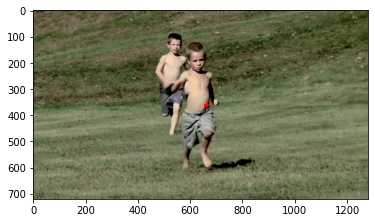

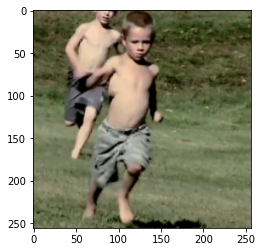

In [39]:
import matplotlib.pyplot as plt
import imageio
import numpy as np
import imgaug.augmenters as iaa
import cv2

def sample_from_bounded_gaussian(x):
    return max(-2*x, min(2*x, np.random.randn()*x))

index=0
imgpath = datasets['dataset']['MPII']['filepath'][1]
while(imgpath!="000001163.jpg"):
  index=index+1
  imgpath = datasets['dataset']['MPII']['filepath'][index]
print('Immagine: '+ imgpath)

img1path = datasets['dataset']['MPII']['filepath'][index]
img1path = imageio.imread('/content/'+img1path)
a = datasets['dataset']['MPII']['people'][index]

nPerson = 0;
if 'scale' in a["info"] :
  print('Scale: '+ str(a["info"]["scale"]))
  x1 = a["info"]["x1"]
  x2 = a["info"]["x2"]
  y1 = a["info"]["y1"]
  y2 = a["info"]["y2"]
  c = [a["info"]["objpos"]["x"],a["info"]["objpos"]["y"]]
  print('objpos: '+ str(c))
  s = a["info"]["scale"]
else:
  print('Scale: '+ str(a["info"][nPerson]["scale"]))
  x1 = a["info"][nPerson]["x1"]
  x2 = a["info"][nPerson]["x2"]
  y1 = a["info"][nPerson]["y1"]
  y2 = a["info"][nPerson]["y2"]
  c = [a["info"][nPerson]["objpos"]["x"],a["info"][nPerson]["objpos"]["y"]]
  print('objpos: '+ str(c))
  s = a["info"][nPerson]["scale"] # scale

c2 = c.copy()             # objpos

cropped = crop(img1path,c2,s,(256,256))

h, w = cropped.shape[0:2]
center = np.array((w/2,h/2))
scale = max(h,w)/200

aug_rot = (np.random.random()*2-1)*30
aug_scale = np. random.random() * (1.25-0.75)+0.75
scale *= aug_scale

mat_mask = get_transform(center, scale, (64,64), aug_rot)[:2]

mat = get_transform(center, scale, (256, 256), aug_rot)[:2]
inp = cv2.warpAffine(cropped, mat, (256, 256)).astype(np.float32)/255

print('\n')

plt.imshow(imageio.imread('/content/'+imgpath))
plt.scatter(c[0],c[1],marker="+",c="r",linewidths=20)
plt.show()


plt.imshow(inp)
plt.show()


In [ ]:
#np.savez_compressed(folder_imgs + '/patches_imgs', np.array(imgs))
#np.load(f"../sartorius/test/imgs/{cellClass}/patches_imgs.npz")['arr_0']

../images_lsp/im0001.jpg
(160, 70, 3)
(1, 14, 2)
(1, 14, 2)
(128, 128, 3)
[ 29.74645941 143.34544031]
[ 54.39352798 114.67635345]


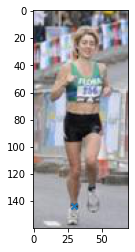

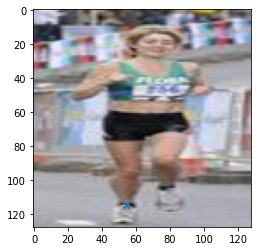

In [ ]:
import imageio
import glob
import imgaug.augmenters as iaa
import numpy as np
from imgaug.augmentables import Keypoint, KeypointsOnImage
import matplotlib.pyplot as plt

"""seq = iaa.Sequential([
    iaa.Affine(
        scale=(0.75, 1.25)
    ) # rotate by exactly 10deg and scale to 50-70%, affects keypoints
    ,
    iaa.Affine(rotate=30),
    iaa.Affine(rotate=330),
    iaa.Fliplr(0.5)
])"""
seq = iaa.Sequential([
    iaa.Resize({"height": 128, "width": 128})
])

lspDataset = datasets["dataset"]["LSP"]
paths = sorted(glob.glob("../images_lsp/*.jpg"))
print(paths[0])
for i in range(1):
    img = imageio.imread(paths[i])
    print(img.shape)
    keypoints = []
    for j in range(14):
        p = lspDataset["keypoints"][i]["points"][j]
        coords = []
        coords.append(p["x"])
        coords.append(p["y"])
        coords = np.array(coords)
        keypoints.append(coords)
    keypoints = np.array(keypoints)
    keypoints = np.reshape(keypoints,(1,)+keypoints.shape)
    print(keypoints.shape)

    img2, kp2 = seq(image=img,keypoints=keypoints)
    print(kp2.shape)
    
    print(img2.shape)
print(keypoints[0][0])
print(kp2[0][0])
plt.imshow(img)
plt.scatter(keypoints[0][0][0],keypoints[0][0][1],marker="x",linewidths=2)
plt.show()
plt.imshow(img2)
plt.scatter(kp2[0][0][0],kp2[0][0][1],marker="x",linewidths=2)
plt.show()


In [ ]:
#Creazione file npy LSP
import imageio
import glob
import imgaug.augmenters as iaa
import numpy as np
from imgaug.augmentables import Keypoint, KeypointsOnImage

lspDataset = datasets["dataset"]["LSP"]
paths = sorted(glob.glob("../images_lsp/*.jpg"))
for i in range(len(paths)):
    img = imageio.imread(paths[i])
    keypoints = []
    for i in range(14):
        p = lspDataset["keypoints"][i]["points"]
        coords = []
        coords.append(p["x"])
        coords.append(p["y"])
        keypoints.append(coords)
    seq = iaa.Sequential([
        iaa.Affine(
            scale=(0.75, 1.25)
        ) # rotate by exactly 10deg and scale to 50-70%, affects keypoints
        ,
        iaa.Sometimes(0.5,iaa.Affine(rotate=30),)
    ])
        
    
    

TypeError: list indices must be integers or slices, not str

Scale: 3.021046176409755
objpos: [594, 257]
16


(16, 64, 64)


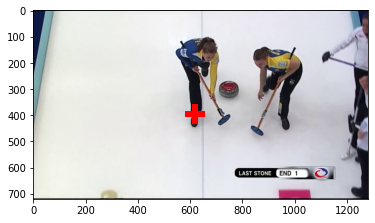

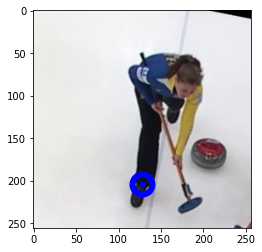

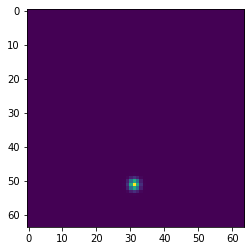

In [47]:
import matplotlib.pyplot as plt
import imageio
import numpy as np
import imgaug.augmenters as iaa
import cv2

def sample_from_bounded_gaussian(x):
    return max(-2*x, min(2*x, np.random.randn()*x))

index=0


img1path = datasets['dataset']['MPII']['filepath'][index]
img1path = imageio.imread(f'../images_mpii/{img1path}')
a = datasets['dataset']['MPII']['people'][index]

nPerson = 0;
if 'scale' in a["info"] :
  print('Scale: '+ str(a["info"]["scale"]))
  x1 = a["info"]["x1"]
  x2 = a["info"]["x2"]
  y1 = a["info"]["y1"]
  y2 = a["info"]["y2"]
  c = [a["info"]["objpos"]["x"],a["info"]["objpos"]["y"]]
  print('objpos: '+ str(c))
  s = a["info"]["scale"]
else:
  print('Scale: '+ str(a["info"][nPerson]["scale"]))
  x1 = a["info"][nPerson]["x1"]
  x2 = a["info"][nPerson]["x2"]
  y1 = a["info"][nPerson]["y1"]
  y2 = a["info"][nPerson]["y2"]
  c = [a["info"][nPerson]["objpos"]["x"],a["info"][nPerson]["objpos"]["y"]]
  print('objpos: '+ str(c))
  s = a["info"][nPerson]["scale"] # scale

c2 = c.copy()             # objpos

cropped = crop(img1path,c2,s,(256,256))



print(len(a["info"][nPerson]["keypoints"]))
orig_keypoints = []
b = a["info"][nPerson]["keypoints"]

for i in b:
    orig_keypoints.append(np.array([i["x"],i["y"]]))

orig_keypoints = np.array(orig_keypoints).reshape((1,16,2))
kptmp = np.copy(orig_keypoints)

for i in range(orig_keypoints.shape[1]):
    if orig_keypoints[0,i,0] > 0:
        orig_keypoints[0,i,:2] = transform(orig_keypoints[0,i,:2], c2, s, (256, 256))

keypoints = np.copy(orig_keypoints)
        
h, w = cropped.shape[0:2]
center = np.array((w/2,h/2))
scale = max(h,w)/200

aug_rot = (np.random.random()*2-1)*30
aug_scale = np. random.random() * (1.25-0.75)+0.75
scale *= aug_scale

mat_mask = get_transform(center, scale, (64,64), aug_rot)[:2]

mat = get_transform(center, scale, (256, 256), aug_rot)[:2]
inp = cv2.warpAffine(cropped, mat, (256, 256)).astype(np.float32)/255

keypoints2 = np.copy(keypoints)#.reshape(-1, 2)
keypointsPlot = np.copy(keypoints)
#keypoints2 = transformKeypoints(keypoints2,center,scale,(256,256),rot=aug_rot)
keypointsPlot[:,:,0:2] = kpt_affine(keypointsPlot[:,:,0:2], mat) #Per plottare su img
keypoints2[:,:,0:2] = kpt_affine(keypoints2[:,:,0:2], mat_mask)



print('\n')


#Flip 50% probability
if np.random.randint(2) == 0:
    inp = inp[:, ::-1]
    keypointsPlot = keypointsPlot[:, flipped_parts['mpii']]
    keypointsPlot[:, :, 0] = 256 - keypointsPlot[:, :, 0]
    keypoints2 = keypoints2[:, flipped_parts['mpii']]
    keypoints2[:, :, 0] = 64 - keypoints2[:, :, 0]
    orig_keypoints = orig_keypoints[:, flipped_parts['mpii']]
    orig_keypoints[:, :, 0] = 256 - orig_keypoints[:, :, 0]

## set keypoints to 0 when were not visible initially (so heatmap all 0s)
    for i in range(np.shape(orig_keypoints)[1]):
        if kptmp[0,i,0] == 0 and kptmp[0,i,1] == 0:
            keypoints2[0,i,0] = 0
            keypoints2[0,i,1] = 0
            orig_keypoints[0,i,0] = 0
            orig_keypoints[0,i,1] = 0
        
heatmaps = generateHeatmap(keypoints2,64,16)

print(heatmaps.shape)

plt.imshow(img1path)
plt.scatter(orig_keypoints2[0,0,0],orig_keypoints2[0,0,1],marker="+",c="r",linewidths=20)
plt.show()


plt.imshow(inp)
plt.scatter(keypointsPlot[0,0,0],keypointsPlot[0,0,1],marker="o",c="b",linewidths=20)
plt.show()

plt.imshow(heatmaps[0])
plt.show()

[0. 1. 2. 3. 4. 5. 6. 7. 8.]
[[0.]
 [1.]
 [2.]
 [3.]
 [4.]
 [5.]
 [6.]
 [7.]
 [8.]]
(9, 1)


Ignora questo pezzettino:
[[0. 1. 2.]
 [3. 4. 5.]
 [6. 7. 8.]]
4.0 4.0
------------

[-4. -3. -2. -1.  0.  1.  2.  3.  4.]
(9,)
(9,)
(9, 1)
(9, 9)
AO:
[[32. 25. 20. 17. 16. 17. 20. 25. 32.]
 [25. 18. 13. 10.  9. 10. 13. 18. 25.]
 [20. 13.  8.  5.  4.  5.  8. 13. 20.]
 [17. 10.  5.  2.  1.  2.  5. 10. 17.]
 [16.  9.  4.  1.  0.  1.  4.  9. 16.]
 [17. 10.  5.  2.  1.  2.  5. 10. 17.]
 [20. 13.  8.  5.  4.  5.  8. 13. 20.]
 [25. 18. 13. 10.  9. 10. 13. 18. 25.]
 [32. 25. 20. 17. 16. 17. 20. 25. 32.]]


G:
[[0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.002 0.007 0.011 0.007 0.002 0.    0.   ]
 [0.    0.002 0.018 0.082 0.135 0.082 0.018 0.002 0.   ]
 [0.    0.007 0.082 0.368 0.607 0.368 0.082 0.007 0.   ]
 [0.    0.011 0.135 0.607 1.    0.607 0.135 0.011 0.   ]
 [0.    0.007 0.082 0.368 0.607 0.368 0.082 0.007 0.   ]
 [0.    0.002 0.018 0.082 0.135 0.082 0.018 0.002 0.   ]


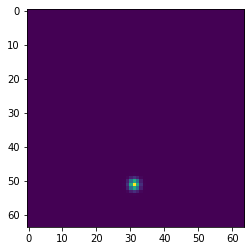

In [90]:
#prove a caso per  capire generateHeatmap
import sys
import numpy as np
import matplotlib.pyplot as plt
x = np.arange(0, 9, 1, float) #crea un array composto da nove 1.0
print(x)
y = x[:, np.newaxis]
print(y)

print(y.shape)
print("\n")
sigma = 1

x0, y0 = 3*sigma + 1, 3*sigma + 1
print("Ignora questo pezzettino:")
print(y.reshape(3,3))
print(x[x0],x[y0])
print("------------\n")
print((x-x0))
print((x-x0).shape)
print(((x-x0)**2).shape) #Okay facendo la potenza element-wise non cambia shape
print((y-y0).shape)
ao = ((x - x0) ** 2 + (y - y0) ** 2) 
print((ao).shape) #qua lo shape cambia (https://numpy.org/doc/stable/user/basics.broadcasting.html)
print("AO:")
print(ao) #osservare attentamente la distribuzione dei valori
print("\n")
g = np.exp(- ((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2))

with np.printoptions(precision=3, suppress=True): #per non far vedere notazione scientifica
    print("G:")
    print(g)  #si ottiene quindi una matrice 9x9 con valori [0-1] in cui ci sono valori alti al centro
print(g.shape)
print("\n")


hms = np.zeros((1,64,64),dtype = np.float32) #creo un heatmap soltanto per provare
print(hms.shape)
print(keypoints2[0,0,0],keypoints2[0,0,1]) #prendo un keypoint dalla precedente cella per provare
x, y = int(keypoints2[0,0,0]), int(keypoints2[0,0,1]) #approssimo il valore float dei keypoints
print(int(keypoints2[0,0,0]), int(keypoints2[0,0,1]))

ul = int(x - 3*sigma - 1), int(y - 3*sigma - 1)
br = int(x + 3*sigma + 2), int(y + 3*sigma + 2)
print("\n")
c,d = max(0, -ul[0]), min(br[0], 64) - ul[0]
a,b = max(0, -ul[1]), min(br[1], 64) - ul[1]
print(f"ul={ul}\nbr={br}\nc,d = {c,d}\na,b={a,b}")
cc,dd = max(0, ul[0]), min(br[0], 64)
aa,bb = max(0, ul[1]), min(br[1], 64)
print(f"cc={cc}\ndd={dd}\naa = {aa}\nbb={bb}\n\n\n")
hms[0, aa:bb,cc:dd] = np.maximum(hms[0, aa:bb,cc:dd], g[a:b,c:d])
with np.printoptions(threshold=sys.maxsize): #Per espandere tutta la matrice 64x64
    prova = np.zeros((64,64))
    prova[ul]=255
    prova[br]=255
    #print(prova) stampa la matrice 64x64 per intero
    #print("\n\n")
    print(prova[27:37,47:57]) #occhio che ho messo 37 e 57 perché altrimenti non avrebbe incluso 36 e 56 e non ti avrebbe fatto vedere l'altro 255
    print(prova[27:37,47:57].shape)
    print(prova[27:36,47:56].shape)

"""
Sostanzialmente noi siamo arrivati a crearci g che è questa finestra 9x9
in cui i pixel diventano più intensi verso il centro.
Noi in generateHeatmap creiamo 16 matrici di dimensione 64x64 con tutti i pixel a 0.
Noi vogliamo accendere i pixel nella posizione del keypoint.
Quindi cosa succede: si assegnano i valori della finestra g, alla finestra della stessa dimensione (9,9)
individuata però sulla heatmap (vedi ul e br) attraverso l'istruzione hms[0, aa:bb,cc:dd] = np.maximum(hms[0, aa:bb,cc:dd], g[a:b,c:d]).
Ovviamente dal momento che hms inizialmente ha tutti i valori a 0, in maximum 'vincerà' sempre g, i cui valori saranno assegnati a hms 

"""

plt.imshow(hms[0])
plt.show()